In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sklearn
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
os.getcwd()

'/home/archie/Projects/h-index-prediction'

In [3]:
def load_dataset(file_name):
    return pd.read_csv(file_name)


In [4]:
df = load_dataset('sientinst_data_merged.csv')

## Table of Contents
* [Chapter 1](#chapter1)
    * [Section 1.1](#section_1_1)
        * [Sub Section 1.1.1](#sub_section_1_1_1)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
        * [Sub Section 2.1.1](#sub_section_2_1_1)
        * [Sub Section 2.1.2](#sub_section_2_1_2)
    * [Section 2.2](#section_2_2)
        * [Sub Section 2.2.1](#sub_section_2_2_1)
        * [Sub Section 2.2.2](#sub_section_2_2_2)
* [Chapter 3](#chapter3)
    * [Section 3.1](#section_3_1)
        * [Sub Section 3.1.1](#sub_section_3_1_1)
        * [Sub Section 3.1.2](#sub_section_3_1_2)
    * [Section 3.2](#section_3_2)
        * [Sub Section 3.2.1](#sub_section_3_2_1)
        * [Sub Section 3.2.2](#sub_section_3_2_2)

## Data cleansing
>_*"the process of detecting and correcting (or removing) corrupt or inaccurate records from a record set, table, or database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data"*_  
~Wikipedia  

Some rows had more than 15 columns, which happend to be a mistake

Data to clean 
* people that do not conduct research 
* people we couldnt find their gender

Columns to edit 
* Position --change to scale from 0 to 4
    0 No Degree
    1 Bachelors Degree
    2 Maters Degree
    3 Doctor Of Philosophy
    4 Proffesor (Part time or Full)
* Categories for contries (with sk label)

Add columns with statistics of each contry such as 
* Human Development Index
* PISA score - Programme for International Student Assessment 
* GDP - gross domestic product

In [5]:
def cleansing(df): # Inplace
    len_before = len(df['Reads'])
    df.drop(df[df['Shanghai_ranking'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Publications'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Reads'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Citations'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Interest score'].str.isnumeric() == False].index, inplace = True)
    len_after = len(df['Reads'])
    print(str(len_before-len_after)+" rows were removed")
    df.to_csv('sientist_data_cleansing', index=False)

In [6]:
cleansing(df)
df.head()

975 rows were removed


Full name  Gender  \
0          Thomas Serre    male   
1       Abdullah Chahin    male   
2     Richard M Mariita    male   
3  Sharon Miriam Swartz  female   
4         Roberto Zenit    male   

                                            Position         Nation  \
0                                                PhD  United States   
1                                                 MD  United States   
2  BEd (Science), MSc (Microbiology) both from Ke...  United States   
3                   Ph.D., The University of Chicago  United States   
4                                              Ph.D.  United States   

          Institute Shanghai_ranking  \
0  Brown University               47   
1  Brown University               47   
2  Brown University               47   
3  Brown University               47   
4  Brown University               47   

                                          Depratment  \
0  Department of Cognitive, Linguistic and Psycho...   
1                   Division of Infectious Diseases    
2                            Department of Chemistry   
3     Department of Ecology and Evolutionary Biology   
4                        Brown School of Engineering   

                                         Disciplines Publications Citations  \
0  Machine Vision|Object Recognition|Machine Lear...          183     11905   
1                 Sepsis|ICU|Intensive Care Medicine           62       234   
2                          Microbiology|Genomics|PCR           39       286   
3                       Zoology|Biomechanics|Mammals          152      4510   
4  Numerical Simulation|Fluid Mechanics|Fluid Dyn...          235      3444   

  Recommendations                                 Top cited research  \
0              64  HMDB51: A Large Video Database for Human Motio...   
1               5             False alarm reduction in critical care   
2              55  Antitubercular and Phytochemical Investigation...   
3              45  The 'Law of Bone Transformation': A Case of Cr...   
4             141        Particle-wall collisions in a viscous fluid   

  Interest score  Reads h index  \
0           6087  33978      40   
1           1379   3586       9   
2           1959   4724       7   
3           2329  37724      39   
4           2294  48142      31   

                                                 URL  
0  https://www.researchgate.net/profile/Thomas-Serre  
1  https://www.researchgate.net/profile/Abdullah_...  
2  https://www.researchgate.net/profile/Richard_M...  
3  https://www.researchgate.net/profile/Sharon-Sw...  
4  https://www.researchgate.net/profile/Roberto-Z...

to find genders of scientists we use the API / Dataset from Facebook https://github.com/philipperemy/name-dataset
using `pip install name-dataset`

In [7]:
from names_dataset import NameDataset, NameWrapper
nd = NameDataset() # uses 3.2 GB of RAM , use with caution 

In [8]:
def find_gender(name):
    try:
        x = nd.search(name)['first_name']['gender']
        if x['Male'] >= x['Female']:
            return 'Male'
        else:
            return 'Female'
    except: 
        return 'NaN'
first_names = df['Full name'].str.split(' ').apply(lambda x: x[0])
genders_list = list()
for name in first_names:
    genders_list.append(find_gender(name))
df['Gender'] = genders_list

the amount of entries to remove (Gender Not defined)

In [9]:
print(str(len(df[df['Gender']=='NaN']))+" sientists were removed (not determied gender)")

2912 sientists were removed (not determied gender)


In [10]:
df.drop(df[df['Gender'] == "NaN"].index ,inplace = True)
df.to_csv('sientist_data_cleansing_geneder_clear.csv', index=False)

In [11]:
df = load_dataset('sientist_data_cleansing_geneder_clear.csv')

in the following cell we remove all people which apear not being a sientists:
that means they have no publications, reads and ect.

In [12]:
try:
    df.drop(["Unnamed: 0"], axis=1, inplace=True)
except:
     print ("")

series_to_remove = df[df['Publications'].astype(int) + df['Citations'].astype(int)
                      + df['Recommendations'].astype(int) + df['Interest score'].astype(int)+
                      df['Reads'].astype(int)+ df['h index'].astype(int) == 0].index

print(str(len(series_to_remove))+" sientists were removed (apear to not being sientists)")

df.drop(series_to_remove, inplace = True);
df.drop_duplicates();


3051 sientists were removed (apear to not being sientists)


### Ouliers

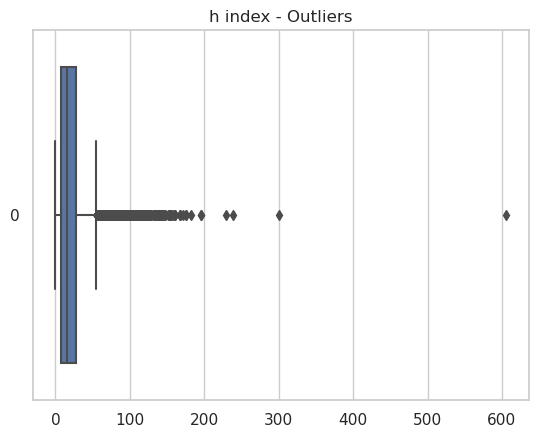

In [13]:
sns.set(style="whitegrid")
sns.boxplot(df["h index"], orient="h");
plt.title("h index - Outliers");

In [14]:
df[df["h index"]>600]

Full name  Gender Position  Nation  \
9265  Cynthia Edenburg  Female      PhD  Israel   

                          Institute  Shanghai_ranking  \
9265  The-Open-University-of-Israel               201   

                                             Depratment  \
9265  Department of History, Philosophy and Judaic S...   

                                        Disciplines  Publications  Citations  \
9265  Distance Education|Online Learning|E-Learning            19         65   

      Recommendations                                 Top cited research  \
9265                0  How (not) to murder a king: Variations on a th...   

      Interest score  Reads  h index URL  
9265              26    338      606   3

In [15]:
df.drop(df[df["h index"]>600].index, inplace = True)

We've search for Cynthia Edenburg, and it seems that her h index is wrongly calcualtely.
So we decide that she's an outlier

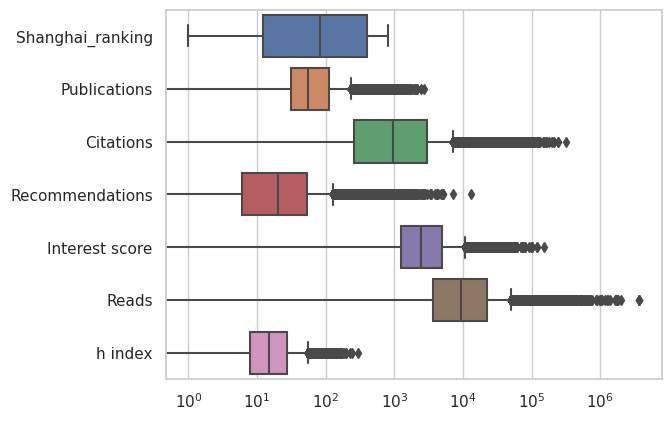

In [16]:
sns.set(style="whitegrid")

# we scale X-axis logaritmically
plt.xscale('log')

sns.boxplot(df, orient="h");

In [17]:
df[df["Reads"]>3500000]

Full name  Gender  \
1705       Goodarz Danaei    Male   
11623  Lital Keinan-Boker  Female   
27472    Regina M Fisberg  Female   

                                          Position         Nation  \
1705   Professor (Associate) at Harvard University  United States   
11623                                 MD, PhD, MPH         Israel   
27472                          Associate Professor         Brazil   

                     Institute  Shanghai_ranking  \
1705        Harvard University                 1   
11623      University-of-Haifa               501   
27472  University-of-Sao-Paulo               101   

                                        Depratment  \
1705   Department of Global Health and Population    
11623                      School of Public Health   
27472          Department of Nutrition (São Paulo)   

                                             Disciplines  Publications  \
1705   Epidemiologic Studies|Hypertension|Epidemiolog...           306   
11623                Cancer|Phytoestrogens|Breast Cancer           297   
27472                  Hypertension|Nutrition|Metabolism           362   

       Citations  Recommendations  \
1705       70185             1306   
11623      25504              759   
27472       6278              429   

                                      Top cited research  Interest score  \
1705   A comparative risk assessment of burden of dis...           35390   
11623  Worldwide trends in body-mass index, underweig...           13242   
27472  Global sodium consumption and death from cardi...            3524   

         Reads  h index                                                URL  
1705   3726175       72  https://www.researchgate.net/profile/Goodarz-D...  
11623  3674694       48  https://www.researchgate.net/profile/Lital-Kei...  
27472  3665645       42                                                NaN

In [18]:
df[df["Recommendations"]>10000]

Full name Gender                                           Position  \
1680  Manu Mangattu   Male  English Professor | Author | NET English Mento...   

             Nation           Institute  Shanghai_ranking  \
1680  United States  Harvard University                 1   

                 Depratment  \
1680  Department of English   

                                            Disciplines  Publications  \
1680  Arts and Humanities|Critical Theory|Literature...           112   

      Citations  Recommendations  \
1680          1            13102   

                                     Top cited research  Interest score  \
1680  Traversing High and Low Culture: Knowledge, We...            3176   

       Reads  h index                                                URL  
1680  693066        1  https://www.researchgate.net/profile/Manu-Mang...

In [19]:
try:
    df.drop(["URL"], axis=1, inplace=True)
except:
     print ("")

we want to add PISA rank & GDP columns:

In [20]:
nation_pisa_science = {"Israel":43, "United States":19, "Great Britain":15, "France":25,
                       "Switzerland":24, "Canada":9, "Japan":6,"China":1,"Turkey":40,
                       "South Korea":8,"Iceland":36,"India":73,"Cyprus":48,"Sweden":20,
                       "Finland":7,"Iran":100,"Malaysia":48,"Italy":40,"Spain":31,"Chile":59,
                       "Brazil":65 ,"Colombia":63,"Mexico":58,"Argentina":65}

nation_GDP = {"Israel":488527, "United States":23315081, "Great Britain":3131378
                      ,"France":2957880 , "Switzerland":800640 , "Canada":1988336
                      ,"Japan":4940878 ,"China":17734063 ,"Turkey":819035
                      ,"South Korea":419015 ,"Iceland":25602 ,"India":3176295
                      ,"Cyprus":28408 ,"Sweden":635664 , "Finland":297302
                      ,"Iran":359713 ,"Malaysia":372981 ,"Italy":2107703
                      ,"Spain":1427381 ,"Chile": 317059 ,"Brazil":1608981
                      ,"Colombia":314464 ,"Mexico":1272839 ,"Argentina":487227}

nation_HDI_score = {"Israel":0.919, "United States":0.921, "Great Britain":0.929, 
                    "France":0.903, "Switzerland":0.962, "Canada":0.936, "Japan":0.925,
                    "China":0.768,"Turkey":0.838,"South Korea":0.925,"Iceland":0.959,
                    "India":0.633,"Cyprus":0.896,"Sweden":0.947,"Finland":0.940,
                    "Iran":0.774,"Malaysia":0.803,"Italy":0.895,"Spain":0.905,
                    "Chile":0.855,"Brazil":0.754 ,"Colombia":0.752,"Mexico":0.758,
                    "Argentina":0.842}

def country_to_pisa_rank(country):
    pisa = []
    for x in country:
        pisa.append(nation_pisa_science[x])
    return pisa

def country_to_GDP(country):
    GDP = []
    for x in country:
        GDP.append(nation_GDP[x])
    return GDP

def country_to_HDI(country):
    HDI = []
    for x in country:
        HDI.append(nation_HDI_score[x])
    return HDI

df['PISA rank'] = country_to_pisa_rank(df['Nation'])
df['GDP (Millions $)'] = country_to_GDP(df['Nation'])
df['HDI score'] = country_to_HDI(df['Nation'])
df.head(2)

Full name Gender Position         Nation         Institute  \
0     Thomas Serre   Male      PhD  United States  Brown University   
1  Abdullah Chahin   Male       MD  United States  Brown University   

   Shanghai_ranking                                         Depratment  \
0                47  Department of Cognitive, Linguistic and Psycho...   
1                47                   Division of Infectious Diseases    

                                         Disciplines  Publications  Citations  \
0  Machine Vision|Object Recognition|Machine Lear...           183      11905   
1                 Sepsis|ICU|Intensive Care Medicine            62        234   

   Recommendations                                 Top cited research  \
0               64  HMDB51: A Large Video Database for Human Motio...   
1                5             False alarm reduction in critical care   

   Interest score  Reads  h index  PISA rank  GDP (Millions $)  HDI score  
0            6087  33978       40         19          23315081      0.921  
1            1379   3586        9         19          23315081      0.921

Scaled categorial variables:
* profesor -> 4
* Ph.D -> 3
* Master -> 2
* Bachelor -> 1
* Other / None -> 0

In [21]:
def position_to_rank(position):
    try:
        position = position.replace(",", "").replace(".", "").replace("_", "").replace("-", "")
        position = position.lower()
    except:
        return 0
    
    if position.find("prof") != -1:
        return 4
    elif position.find("ph") != -1 or position.find("doc") != -1 or position.find("ds") != -1:
        return 3
    elif position.find("md") != -1 or position.find("ma") != -1 or position.find("ms") != -1:
        return 2
    elif position.find("ba") != -1 or position.find("bs") != -1 or position.find("be") != -1:
        return 1
    else:
        return 0

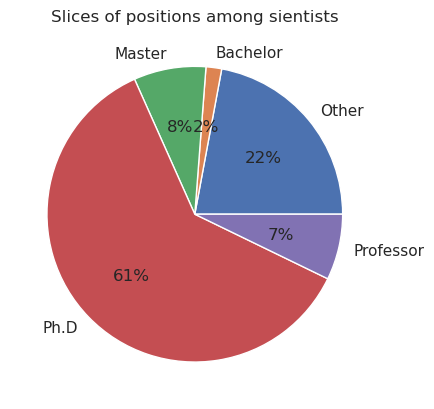

In [22]:
sns.set(style="whitegrid")
edu_rank = []

for pos in df["Position"]:
    val = position_to_rank(pos)
    edu_rank.append(val)

cnt_lst = [edu_rank.count(0), edu_rank.count(1),
          edu_rank.count(2), edu_rank.count(3),
          edu_rank.count(4)]

mylabels = ["Other", "Bachelor", "Master", "Ph.D", "Professor"]

plt.pie(cnt_lst, labels = mylabels, autopct='%1.f%%');
plt.title("Slices of positions among sientists");
# plt.bar(mylabels, cnt_lst);

# adding as an additional column
df['Position rank'] = edu_rank

We see that the majority of the sientists are Ph.D and very few are professors and lower to Ph.D.

We assume that:
* Naturally there are mush less professors than Ph.Ds
* Professors may retired very ofen due to their age, or may be less ambitious than young Ph.Ds
* Professors might be much more buzy in lecturing, pedagogy and other activities rather than in researchs
* Only 2% are Bachelors and it does make sence, because naturally the may countinue to their Master degree or leave the academic enviorment, rather than being involved in researchs
* Many of the Master degrees require a thesis

# Exploratory Data Analysis 
>_*"An approach of analyzing data sets to summarize their main characteristics,  
often using statistical graphics and other data visualization methods"*_  
~Wikipedia

In this section we will disscuse the corallation between the parameters we had collected between themselves and their impact on the h index:

In [23]:
disciplines = df[df['Disciplines'] != "Nan"]['Disciplines'].apply(lambda x:x.split('|'))
L = list()
for entrie in disciplines:
    for item in entrie:
        L.append(item)

text = str()
for item in L: 
    text= text +item +' '

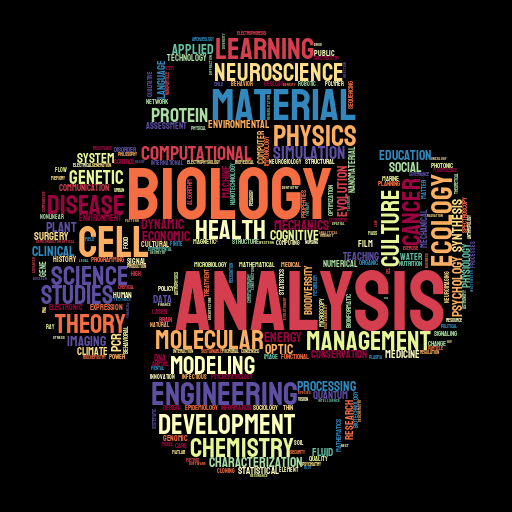

In [24]:
import stylecloud

with open('SJ-Speech.txt', 'w') as f:
    f.write(text)

stylecloud.gen_stylecloud(file_path='SJ-Speech.txt',
                          icon_name='fab fa-python',
                          palette='colorbrewer.diverging.Spectral_11',
                          output_name='cloud.png',
                          background_color='black',
                          collocations=False)

from IPython.display import Image
Image(filename='cloud.png') 

Disciplines which receive nowadays' most attention, according the the database we had collected.

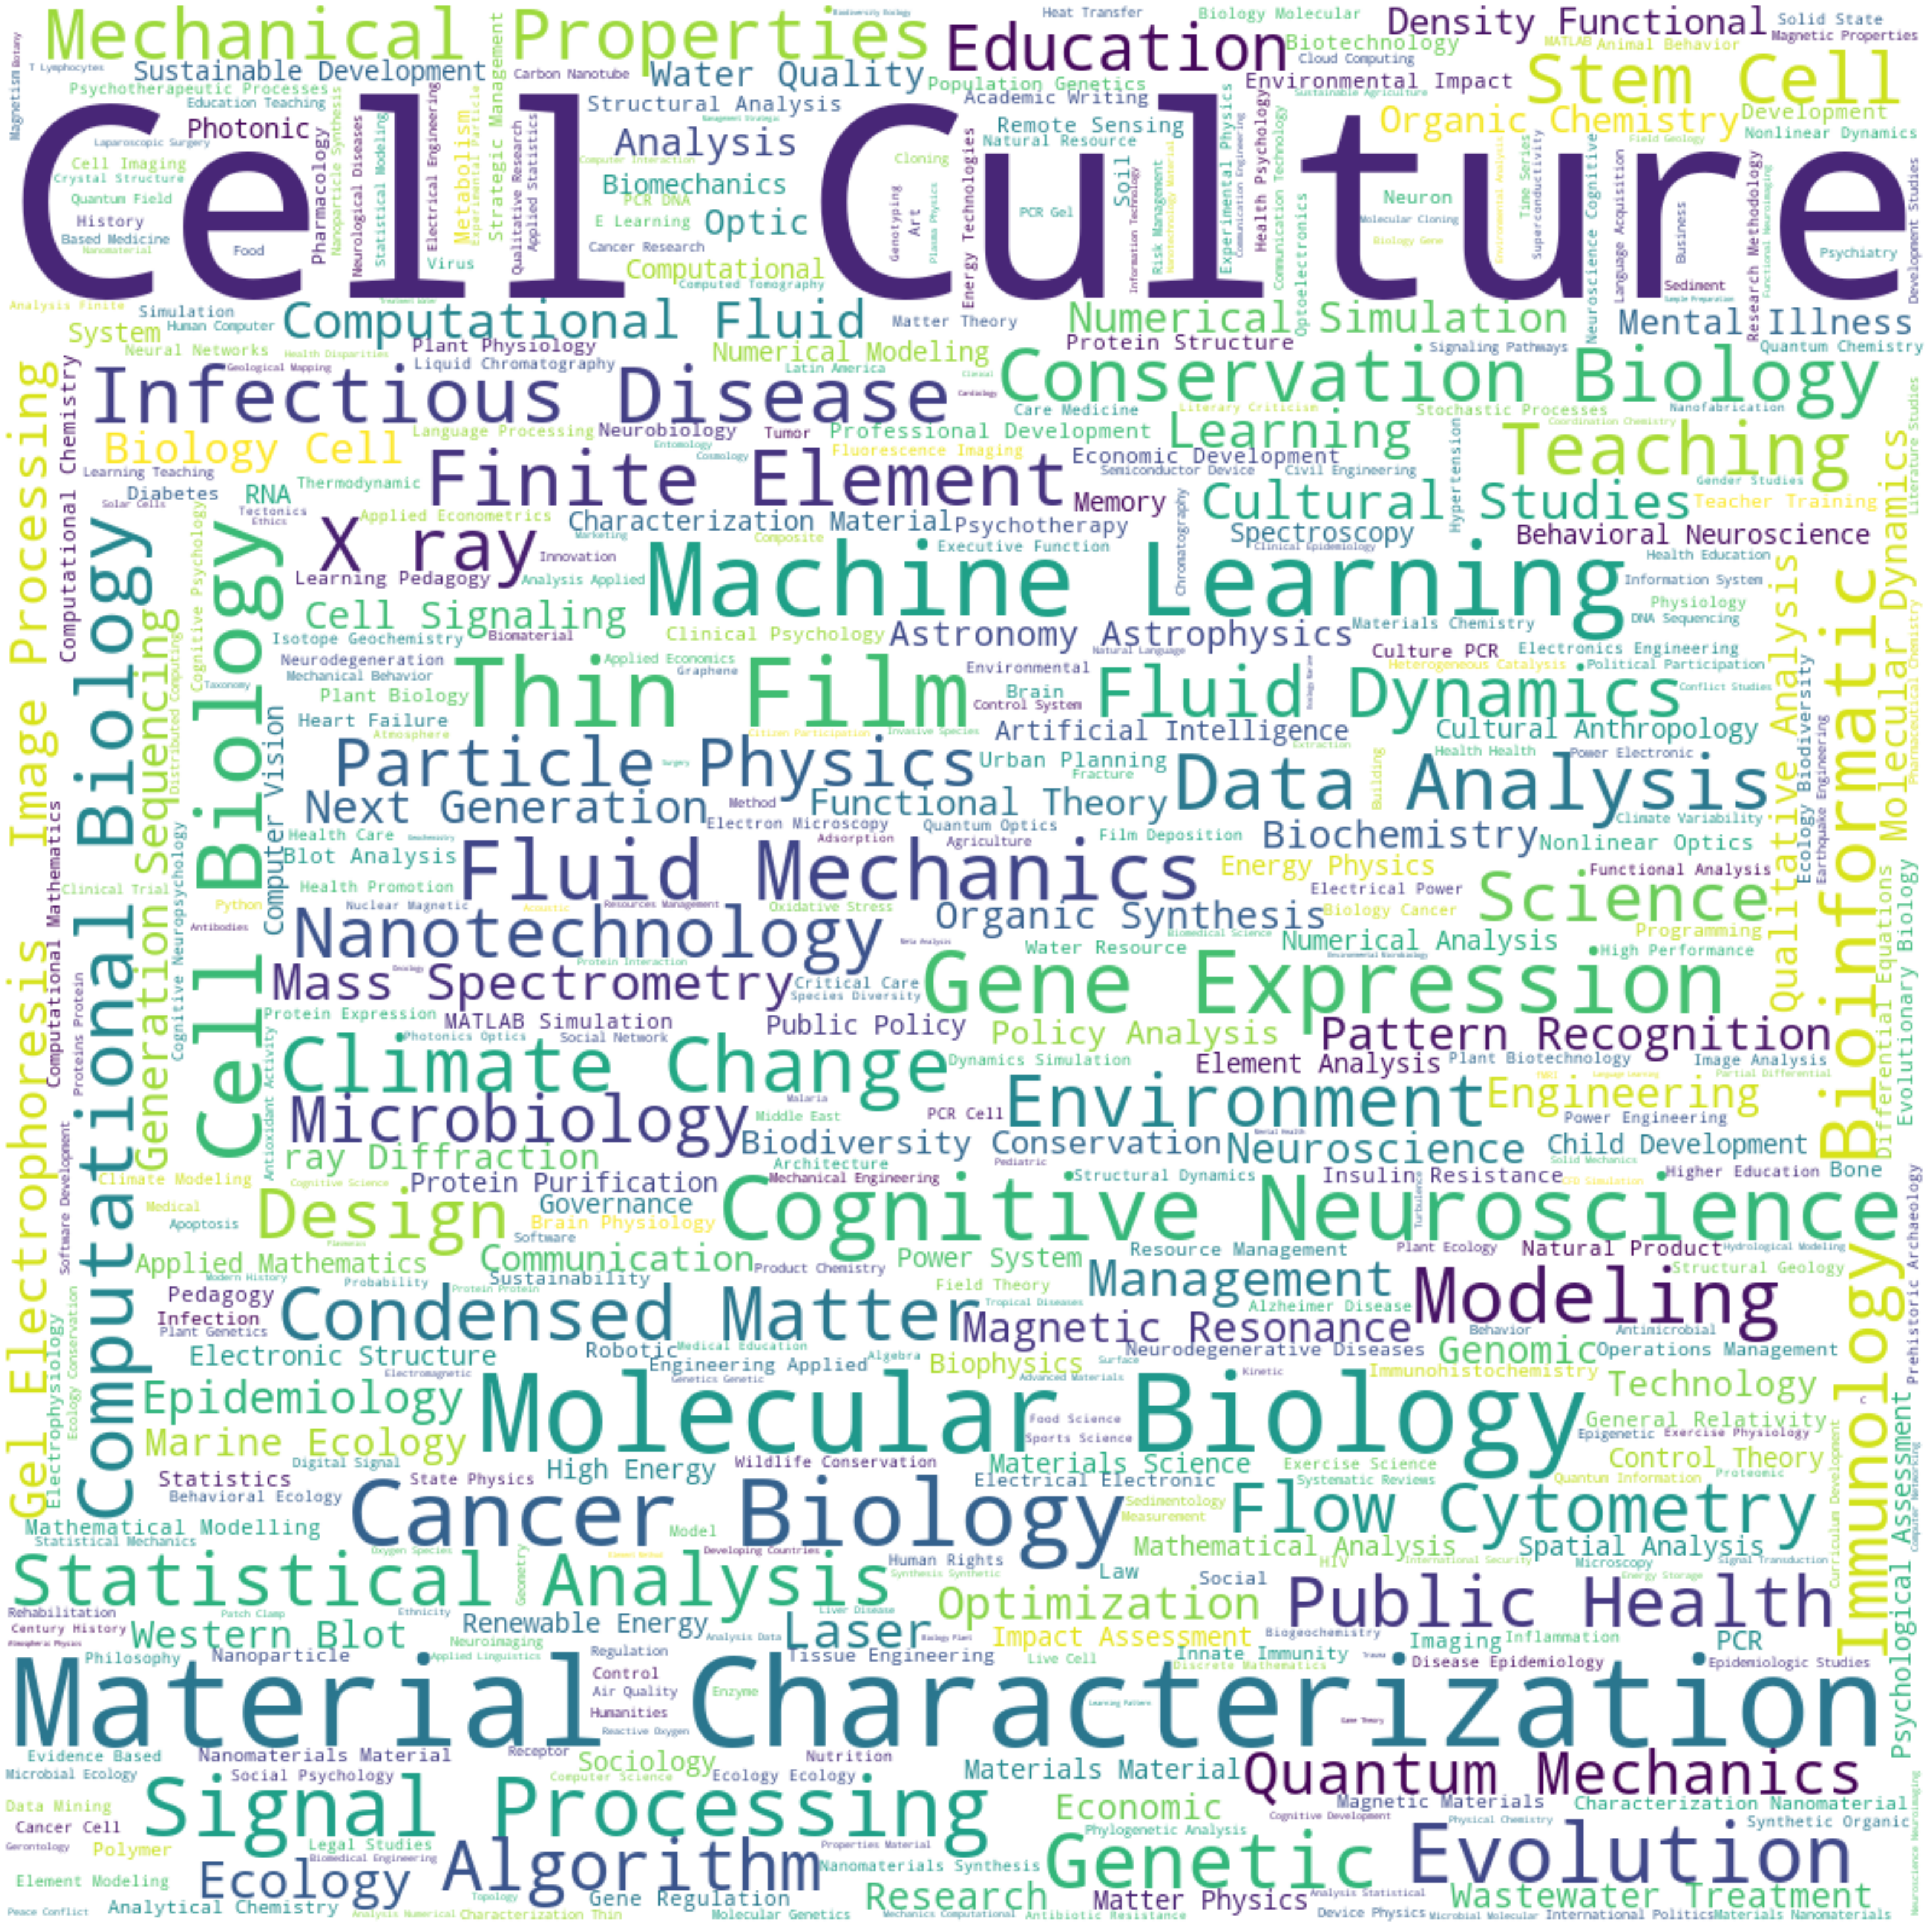

In [25]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(height = 1000, width =1000, max_font_size=200, max_words=500, background_color="white").generate(text)
plt.figure(figsize=(60, 100), dpi=70)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Scatter plots

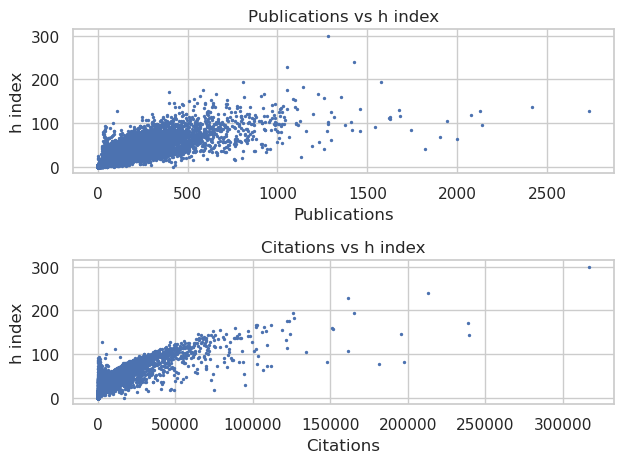

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1)
# fig.suptitle('Correlations to h index')

data={'Publications':df['Publications'].tolist(),
      'h index':df['h index'].tolist()}

tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Publications', y = 'h index', s = 2, ax=ax1);

data={'Citations':df['Citations'].tolist(),
      'h index':df['h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Citations', y = 'h index', s = 2, ax=ax2);

ax1.set_title("Publications vs h index");
ax2.set_title("Citations vs h index");
fig.tight_layout()

* We see that some sientists have very high h index altought they published 'few' researchs and their cirations are moderate. That is probably because their very few researchs were very wide-spread.
* very few sientists whom published few researchs recived low h index, which means that is a key requirment for successing as a scientinst.

__we know that citations and publications are the only factor when calculating the h index.  
we want the see ehat is the impact of the other parameters on the h index, and perhaps we could  
invent a better index for perdicting the success of a sientist__

Here is the others correlations:

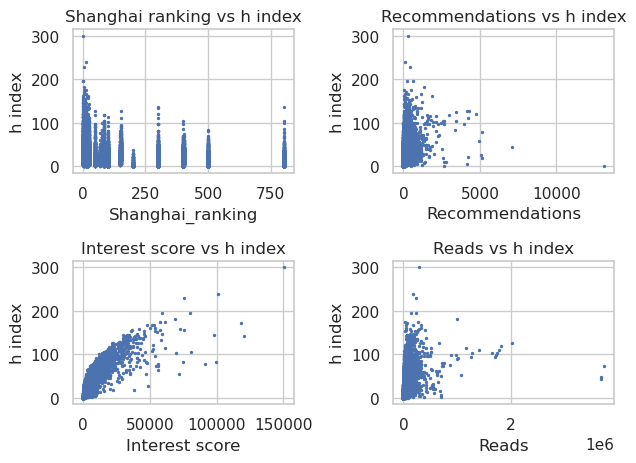

In [27]:
# fig.suptitle('Correlations to h index')

fig, axs = plt.subplots(2, 2)

data={'Shanghai_ranking':df['Shanghai_ranking'].tolist(),
      'h index':df['h index'].tolist()}

tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Shanghai_ranking', y = 'h index', s = 2, ax=axs[0, 0]);

data={'Recommendations':df['Recommendations'].tolist(),
      'h index':df['h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Recommendations', y = 'h index', s = 2, ax=axs[0, 1]);

data={'Interest score':df['Interest score'].tolist(),
      'h index':df['h index'].tolist()}

tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Interest score', y = 'h index', s = 2, ax=axs[1, 0]);

data={'Reads':df['Reads'].tolist(),
      'h index':df['h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Reads', y = 'h index', s = 2, ax=axs[1, 1]);

axs[0, 0].set_title("Shanghai ranking vs h index");
axs[0, 1].set_title("Recommendations vs h index");
axs[1, 0].set_title("Interest score vs h index");
axs[1, 1].set_title("Reads vs h index");
fig.tight_layout()

### Nation analysis

PISA rank and GDP ranking not giving much information. we would try to find the avarage h index for each nation.  

In [28]:
mini_df = df.groupby(['Nation']).mean()["h index"]

avg_h_index = mini_df.tolist()
nations = ['Argentina', 'Brazil', 'Canada', 'Chile', 'China', 'Colombia', 'France',
          'Great Britain', 'Israel', 'Japan', 'Mexico', 'Switzerland', 'United States']

mini_df = pd.DataFrame({"Nation":nations, "Average h index":avg_h_index})

mini_df['PISA rank'] = country_to_pisa_rank(mini_df['Nation'])
mini_df['GDP (Millions $)'] = country_to_GDP(mini_df['Nation'])
mini_df['HDI score'] = country_to_HDI(mini_df['Nation'])
mini_df.head(1)

Nation  Average h index  PISA rank  GDP (Millions $)  HDI score
0  Argentina        13.673216         65            487227      0.842

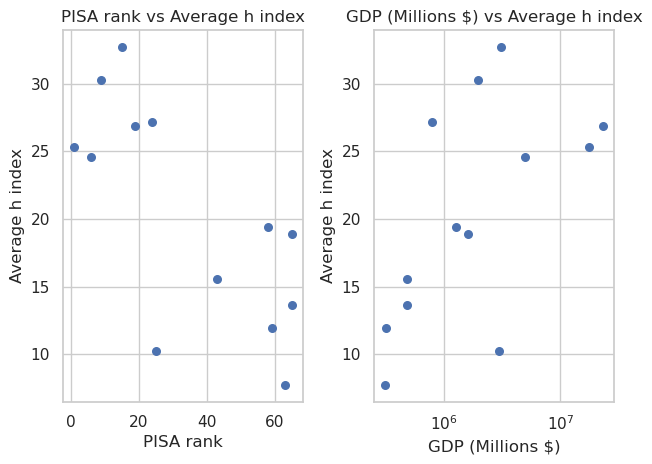

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2)

data={'PISA rank':mini_df['PISA rank'].tolist(),
      'Average h index':mini_df['Average h index'].tolist()}

tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'PISA rank', y = 'Average h index', s = 30, ax=ax1);

data={'GDP (Millions $)':mini_df['GDP (Millions $)'].tolist(),
      'Average h index':mini_df['Average h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'GDP (Millions $)', y = 'Average h index', s = 30, ax=ax2);

ax1.set_title("PISA rank vs Average h index");
ax2.set_title("GDP (Millions $) vs Average h index");
plt.xscale('log')
fig.tight_layout()

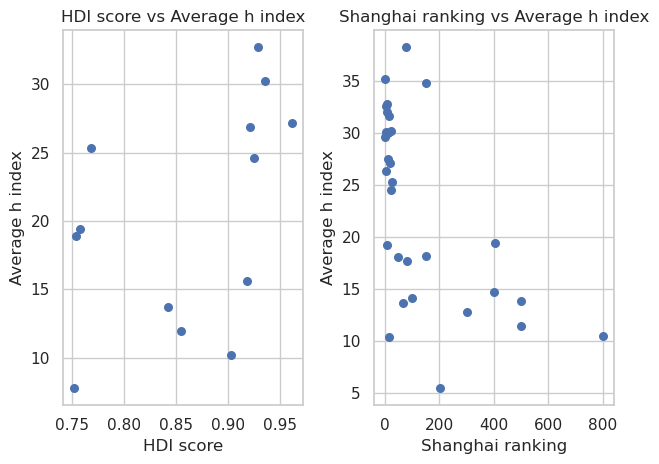

In [30]:
fig, (ax1,ax2) = plt.subplots(1, 2)

data={'HDI score':mini_df['HDI score'].tolist(),
      'Average h index':mini_df['Average h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'HDI score', y = 'Average h index', s = 30, ax=ax1);

ax1.set_title("HDI score vs Average h index");


df_shanghai = df.groupby(['Shanghai_ranking']).mean()["h index"]

Shanghai_ranking = [1,2,3,4,5,6,7,8,11,12,15,16,20,22,24,26,47,67,77,83,101,150,151,201,301,401,405,500,501,801]
lst_avg_per_shanghai = df_shanghai.tolist();

data={'Shanghai ranking':Shanghai_ranking,
      'Average h index':lst_avg_per_shanghai}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Shanghai ranking', y = 'Average h index', s = 30, ax=ax2);

ax1.set_title("HDI score vs Average h index");
ax2.set_title("Shanghai ranking vs Average h index");
fig.tight_layout()

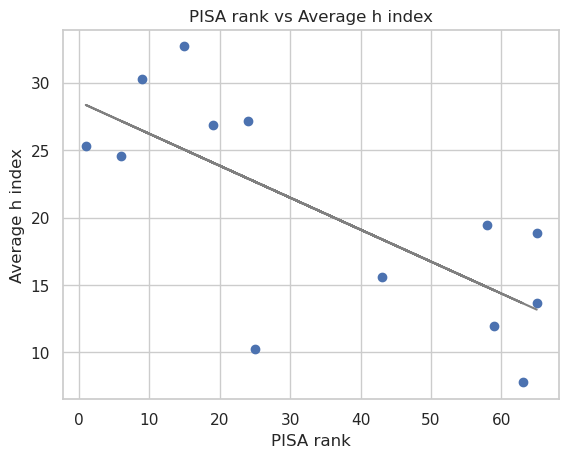

In [31]:
from sklearn.linear_model import LinearRegression

X1 = mini_df[['PISA rank']]
X2 = mini_df[['GDP (Millions $)']]
X3 = mini_df[['HDI score']]
y = mini_df['Average h index']

regressor1 = LinearRegression()
regressor1.fit(X1, y)

regressor2 = LinearRegression()
regressor2.fit(X2, y)

regressor3 = LinearRegression()
regressor3.fit(X3, y)

mini_df2 = pd.DataFrame({"Shanghai ranking":Shanghai_ranking, "Average h index":lst_avg_per_shanghai})
X4 = mini_df2[['Shanghai ranking']]
Y = mini_df2[['Average h index']]

regressor4 = LinearRegression()
regressor4.fit(X4, Y)

plt.scatter(X1, y)
plt.plot(X1, regressor1.predict(X1), color = "grey")

# plt.scatter(X2, y)
# plt.plot(X2, regressor2.predict(X2), color = "grey")
plt.title('PISA rank vs Average h index')
plt.xlabel('PISA rank')
plt.ylabel('Average h index')
plt.show()

In [32]:
print('PISA rank vs Average h index:\n\tR-squared = {:.3f}'.format(r2_score(y, regressor1.predict(X1))))
print('\tPearson correlation coefficient = R = {:.3f}'.format(mini_df.corr()['PISA rank'][0])+'\n')
print('GDP vs Average h index:\n\tR-squared = {:.3f}'.format(r2_score(y, regressor2.predict(X2))))
print('\tPearson correlation coefficient = R = {:.3f}'.format(mini_df.corr()['GDP (Millions $)'][0])+'\n')
print('HDI vs Average h index:\n\tR-squared = {:.3f}'.format(r2_score(y, regressor3.predict(X3))))
print('\tPearson correlation coefficient = R = {:.3f}'.format(mini_df.corr()['HDI score'][0])+'\n')
print('Shanghai ranking vs Average h index:\n\tR-squared = {:.3f}'.format(r2_score(Y, regressor4.predict(X4))))
print('\tPearson correlation coefficient = R = {:.3f}'.format(mini_df2.corr()['Shanghai ranking'][1]))

PISA rank vs Average h index:
	R-squared = 0.524
	Pearson correlation coefficient = R = -0.724

GDP vs Average h index:
	R-squared = 0.157
	Pearson correlation coefficient = R = 0.396

HDI vs Average h index:
	R-squared = 0.213
	Pearson correlation coefficient = R = 0.462

Shanghai ranking vs Average h index:
	R-squared = 0.343
	Pearson correlation coefficient = R = -0.586


* PISA rank of a nations is a good indicator for which country produce better scientists.  
* On the other hand, GDP has low impact, We assume it to be logarithmically (as we scale the x axis logarithmically it seems to have 'linear' correlation)
* We were suprised that the HDI score of a nation have a very little impact on the quality of its scientists

In [33]:
df.corr()["h index"].sort_values()

Shanghai_ranking   -0.301562
PISA rank          -0.289788
Position rank       0.053868
HDI score           0.173123
GDP (Millions $)    0.245993
Recommendations     0.296905
Reads               0.382567
Interest score      0.643960
Citations           0.791692
Publications        0.798109
h index             1.000000
Name: h index, dtype: float64

__In order to echive a higher corollations, We shall remove:__
* scientists whom hadn't decladered their level of degree or position in their institue.
* scientists whos publiction and citation are 0.

In [34]:
alternate_df = df[df['Position rank']>0]
alternate_df.corr()["h index"].sort_values()

Shanghai_ranking   -0.270394
PISA rank          -0.269722
Position rank       0.133634
HDI score           0.168352
GDP (Millions $)    0.216664
Recommendations     0.294765
Reads               0.375411
Interest score      0.621723
Publications        0.798140
Citations           0.799598
h index             1.000000
Name: h index, dtype: float64

We percive that the position rank has a very weak impact upon the h index.  
After removing all undecladered degree's scientists, and undergraduats, the improvement is from 0.047010 to 0.133629.  
We decide not removing those rows.

In [35]:
alternate_df = df[df['Publications']>0]
alternate_df = alternate_df[alternate_df['Citations']>0]
alternate_df.corr()["h index"].sort_values()

Shanghai_ranking   -0.295102
PISA rank          -0.286836
Position rank       0.034476
HDI score           0.175393
GDP (Millions $)    0.236937
Recommendations     0.295304
Reads               0.380229
Interest score      0.638217
Citations           0.793754
Publications        0.795960
h index             1.000000
Name: h index, dtype: float64

Again, removing scientists whom have no Publications and Citations have very weak improvement in the correlation with the h index

### Gender analysis

First, we wish to know, whether Male or Female are the majority in each academic positions:

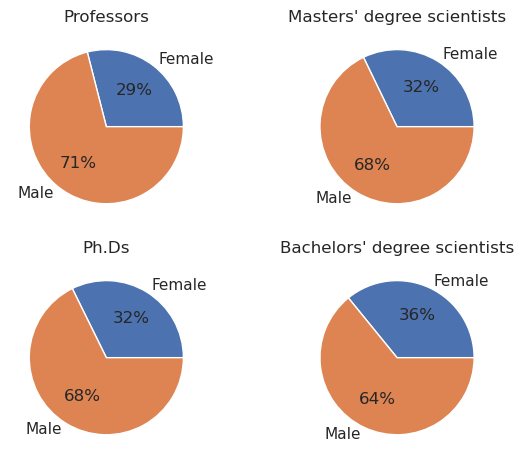

In [36]:
fig, axs = plt.subplots(2, 2)

mylabels = ['Female','Male']

tmp = df[df['Position rank'] == 4]
F_prof = len(tmp[tmp['Gender'] == 'Female'])
M_prof = len(tmp[tmp['Gender'] == 'Male'])

axs[0, 0].pie([F_prof, M_prof], labels = mylabels, autopct='%1.f%%');
axs[0, 0].set_title("Professors");

tmp = df[df['Position rank'] == 3]
F_phd = len(tmp[tmp['Gender'] == 'Female'])
M_phd = len(tmp[tmp['Gender'] == 'Male'])

axs[1, 0].pie([F_phd, M_phd], labels = mylabels, autopct='%1.f%%');
axs[1, 0].set_title("Ph.Ds");

tmp = df[df['Position rank'] == 2]
F_master = len(tmp[tmp['Gender'] == 'Female'])
M_master = len(tmp[tmp['Gender'] == 'Male'])

axs[0, 1].pie([F_master, M_master], labels = mylabels, autopct='%1.f%%');
axs[0, 1].set_title("Masters' degree scientists");

tmp = df[df['Position rank'] == 1]
F_bachelor = len(tmp[tmp['Gender'] == 'Female'])
M_bachelor = len(tmp[tmp['Gender'] == 'Male'])

axs[1, 1].pie([F_bachelor, M_bachelor], labels = mylabels, autopct='%1.f%%');
axs[1, 1].set_title("Bachelors' degree scientists");

fig.tight_layout()

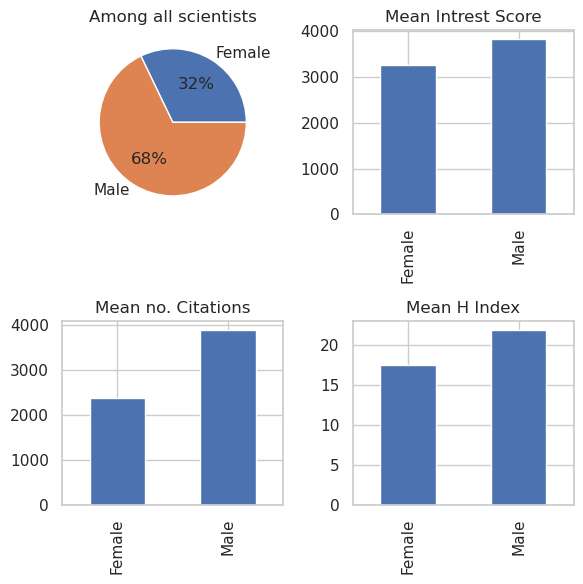

In [37]:
fig = plt.figure(figsize=(6,6))
ax_1 = plt.subplot(221); df.groupby(by=["Gender"]).count()['Institute'].plot(ylabel='', kind ='pie' , ax=ax_1 , title = 'Among all scientists', autopct='%1.f%%'); #pie chart count
ax_2 = plt.subplot(222); df.groupby(by=["Gender"]).mean()['Interest score'].plot(xlabel='',kind ='bar' , ax=ax_2,title='Mean Intrest Score'); #mean intrest value
ax_3 = plt.subplot(223); df.groupby(by=["Gender"]).mean()['Citations'].plot(xlabel='',kind ='bar' , ax=ax_3 , title='Mean no. Citations');#mean 
ax_4 = plt.subplot(224); df.groupby(by=["Gender"]).mean()['h index'].plot(xlabel='', kind ='bar' , ax=ax_4 , title='Mean H Index');#mean
fig.tight_layout()

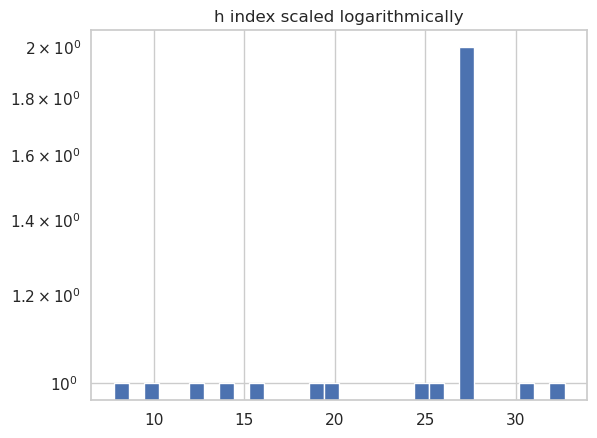

In [38]:
plt.hist(y, bins=30);
plt.yscale('log')
plt.title("h index scaled logarithmically");

After scaling the h index logarithmically, the decreasion apear to be linear. It means that the higher the h index is the amount of people decreased exponnetially.

# Machine learning models
Now we will remove all columns which irrelevant for the model:
* Gende -> covert to Female to 0 and Male to 1
* remove 'Full name'
* remove 'Position'
* remove 'Nation'
* remove 'Disciplines'
* remove 'Depratment'
* remove 'Institute'
* remove 'Top cited research'

## Preparations

In [39]:
import sklearn
model_df = df.drop(['Full name', 'Institute', 'Position', 'Nation', 
                    'Disciplines', 'Depratment', 'Top cited research'], axis=1)

le = sklearn.preprocessing.LabelEncoder()
model_df['Gender'] = le.fit_transform(model_df.Gender) 

# adding an average h index of a nation
Average_h_index = {"Israel":15.593223, "United States":26.894334, "Great Britain":32.698174, 
                   "France":10.220755, "Switzerland":27.167742, "Canada":30.270510, 
                   "Japan":24.569689,"China":25.345938,"Chile":11.978551,"Brazil":18.869754,
                   "Colombia":7.764674,"Mexico":19.434924,"Argentina":13.673216}

def country_to_average_h_index(country):
    avg = []
    for x in country:
        avg.append(Average_h_index[x])
    return avg

model_df['Average h index'] = country_to_average_h_index(df['Nation'])

model_df.to_csv('DataFrame_for_model.csv', index=False)

loading the dataset

In [40]:
model_df = load_dataset('DataFrame_for_model.csv')

try:
    df.drop(["Unnamed: 0"], axis=1, inplace=True)
except:
     print ("")

In [41]:
model_df

Gender  Shanghai_ranking  Publications  Citations  Recommendations  \
0           1                47           183      11905               64   
1           1                47            62        234                5   
2           1                47            39        286               55   
3           0                47           152       4510               45   
4           1                47           235       3444              141   
...       ...               ...           ...        ...              ...   
33716       1               401             0          0                0   
33717       0               401            33        229                0   
33718       1               401             0          0                0   
33719       1               401             0          0                0   
33720       1               401             0          0                0   

       Interest score  Reads  h index  PISA rank  GDP (Millions $)  HDI score  \
0                6087  33978       40         19          23315081      0.921   
1                1379   3586        9         19          23315081      0.921   
2                1959   4724        7         19          23315081      0.921   
3                2329  37724       39         19          23315081      0.921   
4                2294  48142       31         19          23315081      0.921   
...               ...    ...      ...        ...               ...        ...   
33716               0      4        0         59            317059      0.855   
33717            1086    320        7         59            317059      0.855   
33718               0      2        0         59            317059      0.855   
33719               0      1        0         59            317059      0.855   
33720               0     14        0         59            317059      0.855   

       Position rank  Average h index  
0                  3        26.894334  
1                  2        26.894334  
2                  3        26.894334  
3                  3        26.894334  
4                  3        26.894334  
...              ...              ...  
33716              0        11.978551  
33717              0        11.978551  
33718              0        11.978551  
33719              0        11.978551  
33720              0        11.978551  

[33721 rows x 13 columns]

We will use linear regression to attempt at predicting the h-index of a given researcher based on the metrics we have in our dataset. First let's write the function that loads the dataset from file and sepearates the h-index column from the rest of the dataset.

In [88]:
def load_dataset(file_name, target_column):
    df = pd.read_csv(file_name)
    return df.drop([target_column], axis=1), df[target_column].copy()

And now we can reload our dataset , normalize it , split it to train and test sets , and train our model using SkLearn built in tools 

In [89]:
from sklearn.model_selection import train_test_split
file_name = 'DataFrame_for_model.csv'
target_col_name = 'h index'
try:
    X , y= load_dataset(file_name, target_col_name)
    X_train, X_test, y_train, y_test = train_test_split(X,y , random_state=42)
    
except Exception as e:
    print ('\tError Message:', str(e))
    raise 

## Trying diffrent machine learning algorithms


### Linear Regression

In [90]:
clf = sklearn.linear_model.LinearRegression()
clf.fit(X_train,y_train)

LinearRegression()

Let's evaluate the performance of out model,


First, we'll take a look in the $SSE$ and $R^2$ scores.



In [91]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
y_predict = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))
print(f"SSE = {mean_squared_error(y_test , np.floor(y_predict))}  " )
print(f"R2 = {r2_score(y_test , np.floor(y_predict))}")

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

It seems that linear regression gives us a good result , we may improve it by creating new features for our model: 
A note of context - the ['Interest Score'](https://explore.researchgate.net/display/support/Research+Interest+Score) is calculated by the website ResearchGate and is consistent of the amount of a researcher's citations , reads and recommendations. 
DRAFT: ideas - citations/publications , remove people with 0 position rank & people with no publications

### Random Forest 

The algorithm builds a large number of decision trees, each trained on a random subset of the training data and a random subset of the features. The final prediction is then made by averaging or voting the predictions of the individual trees. This technique helps to reduce overfitting and improve the accuracy of the model. 

Training

First , let's make little adjustments to our dataframe. To not imply an hierarcial order between items in the categorial variables such as the researcher's institute, thier degree or the country they come from, we seperate these columns to have a binary representation of inclusion in each category. an efficient way to do so will be by utullizing `pd.get_dummies`

In [83]:
X_train

Position  Shanghai_ranking  \
7295                                          PhD                12   
34977                                       Ph.D.               801   
2210                                          PhD                11   
10314                                         PhD               401   
28315                        Doctor of Philosophy               101   
...                                           ...               ...   
19163                                       Ph.D.                 5   
6332   Research Associate at Princeton University                 6   
11787                                         PhD               501   
860                                          M.D.                47   
18108                                        Ph.D                 3   

       Publications  Citations  Recommendations  Interest score  Reads  \
7295             25       1131               11            6058  10662   
34977           145       3898              130            1756  26143   
2210             69       1359               10            7669  11383   
10314            24        119                7             614   1000   
28315            22         52                4             353   1710   
...             ...        ...              ...             ...    ...   
19163           100       5814               42            3212  38529   
6332              9         67                7             470   1081   
11787            47        356               60            4942  19735   
860              14        219                7            1331   3659   
18108            30       1694               63            9964  12672   

       h index  PISA rank  GDP (Millions $)  ...  Nation_Chile  Nation_China  \
7295        12         19          23315081  ...             0             0   
34977       32         65           1608981  ...             0             0   
2210        18         19          23315081  ...             0             0   
10314        8         43            488527  ...             0             0   
28315        4         63            314464  ...             0             0   
...        ...        ...               ...  ...           ...           ...   
19163       35         19          23315081  ...             0             0   
6332         4         19          23315081  ...             0             0   
11787       11         43            488527  ...             0             0   
860          7         19          23315081  ...             0             0   
18108       13         19          23315081  ...             0             0   

       Nation_Colombia  Nation_France  Nation_Great Britain  Nation_Israel  \
7295                 0              0                     0              0   
34977                0              0                     0              0   
2210                 0              0                     0              0   
10314                0              0                     0              1   
28315                1              0                     0              0   
...                ...            ...                   ...            ...   
19163                0              0                     0              0   
6332                 0              0                     0              0   
11787                0              0                     0              1   
860                  0              0                     0              0   
18108                0              0                     0              0   

       Nation_Japan  Nation_Mexico  Nation_Switzerland  Nation_United States  
7295              0              0                   0                     1  
34977             0              0                   0                     0  
2210              0              0                   0                     1  
10314             0              0                   0                     0  
28315 

In [84]:
df_randforst = df.drop(['Full name', 'Disciplines', 'Depratment', 'Top cited research'], axis=1)

y= df['h index']
target_col_name = 'h index'
categories =  ['Gender', 'Position', 'Institute' ,'Nation']
X = pd.get_dummies(df_randforst, columns=categories)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [85]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=100)
forest.fit(X_train , y_train)
y_predict = forest.predict(X_test)

Evaluation 

In [86]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))

Accuracy: 0.40374807258925394
